In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

import pandas as pd
import numpy as np
import torch
from functools import partial
import pytorch_lightning as pl
import warnings
import pickle
warnings.filterwarnings("ignore")


from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.preprocessing import PandasDataPreprocessor

from tqdm import tqdm

In [ ]:
from lct_2024.utils import prepare_train_dl, get_train_dataset, get_val_dataset, get_test_dataset

In [ ]:
# Нужно чтобы вытащить номера месяцев для разбиения на фолды по дате
target_train = pd.read_parquet("../data/train_target.parquet")
target_test = pd.read_parquet("../data/test_target_b.parquet")

# Транзакции

# Данные

In [ ]:
transactions_train = pd.read_parquet("../data/trx_train.parquet")
transactions_test = pd.read_parquet("../data/trx_test.parquet")

In [ ]:
preprocessor = PandasDataPreprocessor(
    col_id="client_id",
    col_event_time="event_time",
    event_time_transformation="dt_to_timestamp",
    cols_category=["event_type",
                   "event_subtype",
                   "currency",
                   "src_type11",
                   "src_type12",
                   "dst_type11",
                   "dst_type12",
                   "src_type21",
                   "src_type22",
                   "src_type31",
                   "src_type32"],
    cols_identity="amount",
    return_records=False,
)
with open('../data/transformers/transactions_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:
processed_train = preprocessor.transform(transactions_train)
processed_train.to_pickle('../data/trans_processed_train.pkl')

In [ ]:
processed_test = preprocessor.transform(transactions_test)
processed_test.to_pickle('../data/trans_processed_test.pkl')

In [ ]:
train_dl = prepare_train_dl(processed_train, processed_test, min_seq_len=128, batch_size=128)

## Модель

In [ ]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={"amount": "log"},
    embeddings={
        "event_type": {"in": preprocessor.get_category_dictionary_sizes()["event_type"], "out": 8,},
        "event_subtype": {"in": preprocessor.get_category_dictionary_sizes()["event_subtype"], "out": 8,},
        "src_type11": { "in": preprocessor.get_category_dictionary_sizes()["src_type11"], "out": 16,},
        "src_type12": {"in": preprocessor.get_category_dictionary_sizes()["src_type12"], "out": 16,},
        "dst_type11": {"in": preprocessor.get_category_dictionary_sizes()["dst_type11"], "out": 16,},
        "dst_type12": {"in": preprocessor.get_category_dictionary_sizes()["dst_type12"], "out": 16,},
        "src_type22": {"in": preprocessor.get_category_dictionary_sizes()["src_type22"], "out": 16},
        "src_type31": {"in": preprocessor.get_category_dictionary_sizes()["src_type31"], "out": 16,},
        "src_type32": {"in": preprocessor.get_category_dictionary_sizes()["src_type32"], "out": 16,},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=64,
    type="gru",
)
model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(
        torch.optim.lr_scheduler.StepLR, step_size=3, gamma=0.9025
    ),
)
trainer = pl.Trainer(
    max_epochs=30,
    limit_val_batches=5000,
    enable_progress_bar=True,
    gradient_clip_val=0.5,
    logger=pl.loggers.TensorBoardLogger(save_dir="./logdir", name="transaction_result"),
    callbacks=[
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        pl.callbacks.ModelCheckpoint(every_n_train_steps=5000, save_top_k=-1),
        pl.callbacks.EarlyStopping(monitor="valid/recall_top_k", mode="max", patience=5),
        pl.callbacks.EarlyStopping(monitor="loss", mode="min", patience=3),
    ],
)

In [ ]:
trainer.fit(model, train_dl)

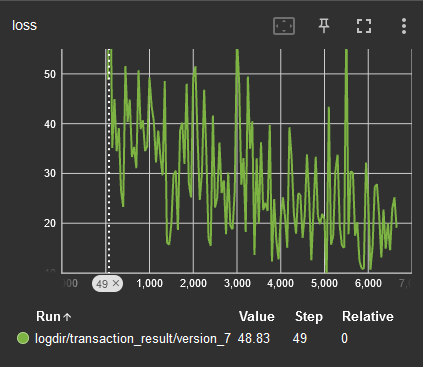

In [ ]:
torch.save(model.state_dict(), "../data/models/transactions_emb64_model.pt")

## Эмбеддинги

In [ ]:
device  = torch.device("cuda")
model = model.to(device)

train_emb_df = get_train_dataset(processed_train, model, sorted(target_train.mon.sort_values().unique()), device)
val_emb_df = get_val_dataset(processed_test, model, sorted(target_test.mon.sort_values().unique()), device)
test_emb_df = get_test_dataset(processed_test, model, device)

In [ ]:
train_emb_df.to_csv('../data/train_trans_emb_v8.csv', index=False)
val_emb_df.to_csv('../data/val_trans_emb_v8.csv', index=False)
test_emb_df.to_csv('../data/test_trans_emb_v8.csv', index=False)

# Гео

## Данные

In [ ]:
geo_train = pd.read_parquet("../data/geo_train.parquet")
geo_test = pd.read_parquet("../data/geo_test.parquet")

In [ ]:
preprocessor = PandasDataPreprocessor(
    col_id="client_id",
    col_event_time="event_time",
    event_time_transformation="dt_to_timestamp",
    cols_category=["geohash_4", "geohash_5", "geohash_6",],
    return_records=False,
)
preprocessor = preprocessor.fit(geo_train)
with open('../data/transformers/geo_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:
processed_train = preprocessor.transform(geo_train)
processed_train.to_pickle('../data/geo_processed_train.pkl')

In [ ]:
processed_test = preprocessor.transform(geo_test)
processed_test.to_pickle('../data/geo_processed_test.pkl')

In [ ]:
train_dl = prepare_train_dl(processed_train, processed_test, min_seq_len=64, batch_size=256)

## Модель

In [ ]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    embeddings={
        'geohash_4': {'in': preprocessor.get_category_dictionary_sizes()["geohash_4"], 'out': 24},
        'geohash_5': {'in': preprocessor.get_category_dictionary_sizes()["geohash_5"], 'out': 24},
        'geohash_6': {'in': preprocessor.get_category_dictionary_sizes()["geohash_6"], 'out': 24},
    }
)

In [ ]:
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=64,
    type='gru',
)

In [ ]:
model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=3, gamma=0.9025)
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=30,
    limit_val_batches=5000,
    # gpus=[0],
    enable_progress_bar=True,
    gradient_clip_val=0.5,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='./logdir',
        name='geo_result'
    ),
    callbacks=[
        pl.callbacks.LearningRateMonitor(logging_interval='step'),
        pl.callbacks.ModelCheckpoint(every_n_train_steps=5000, save_top_k=-1),
        pl.callbacks.EarlyStopping(monitor="valid/recall_top_k", mode="max", patience=5),
        pl.callbacks.EarlyStopping(monitor="loss", mode="min", patience=3),
    ]
)

In [ ]:
trainer.fit(model, train_dl)

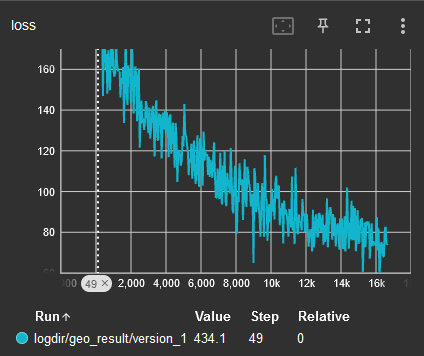

In [ ]:
torch.save(model.state_dict(), '../data/models/geo_emb64_model.pt')

## Эмбеддинги

In [ ]:
device  = torch.device("cuda")
model = model.to(device)

train_emb_df = get_train_dataset(processed_train, model, sorted(target_train.mon.sort_values().unique()), device)
val_emb_df = get_val_dataset(processed_test, model, sorted(target_test.mon.sort_values().unique()), device)
test_emb_df = get_test_dataset(processed_test, model, device)

In [ ]:
train_emb_df.to_csv('../data/train_geo_emb_v8.csv', index=False)
val_emb_df.to_csv('../data/val_geo_emb_v8.csv', index=False)
test_emb_df.to_csv('../data/test_geo_emb_v8.csv', index=False)

# Диалоги

## Данные

In [ ]:
dial_train = pd.read_parquet("../data/dial_train.parquet")
dial_test = pd.read_parquet("../data/dial_test.parquet")

In [ ]:
# для ускорения вычислений (eco:))
from sklearn.decomposition import PCA


pca = PCA(n_components = 0.865)
reduced_train = pca.fit_transform(dial_train[['embedding']].apply(lambda x: x['embedding'], result_type="expand", axis=1))
reduced_test = pca.transform(dial_test[['embedding']].apply(lambda x: x['embedding'], result_type="expand", axis=1))

In [ ]:
dial_train = pd.concat([dial_train[['client_id', 'event_time']], pd.DataFrame(reduced_train, columns=[f'emb_{i}' for i in range(reduced_train.shape[1])])], axis='columns')
dial_test = pd.concat([dial_test[['client_id', 'event_time']], pd.DataFrame(reduced_test, columns=[f'emb_{i}' for i in range(reduced_train.shape[1])])], axis='columns')

In [ ]:
preprocessor = PandasDataPreprocessor(
    col_id="client_id",
    col_event_time="event_time",
    event_time_transformation="dt_to_timestamp",
    cols_numerical=[f'emb_{i}' for i in range(reduced_train.shape[1])],
    return_records=False,
)
preprocessor = preprocessor.fit(dial_train)
with open('../data/transformers/dial_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:
# Сохраняемся, чтобы не расчитывать заново
processed_train = preprocessor.transform(dial_train)
processed_train.to_pickle('../data/dial_processed_train.pkl')

processed_test = preprocessor.transform(dial_test)
processed_test.to_pickle('../data/dial_processed_test.pkl')

In [ ]:
train_dl = prepare_train_dl(processed_train, processed_test, min_seq_len=8, batch_size=256)

## Модель

In [ ]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={f'emb_{i}': 'log' for i in range(8)},
)
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=64,
    type='gru',
)
model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=3, gamma=0.9025)
)

trainer = pl.Trainer(
    max_epochs=30,
    limit_val_batches=5000,
    # gpus=[0],
    enable_progress_bar=True,
    gradient_clip_val=0.5,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='./logdir',
        name='dial_result'
    ),
    callbacks=[
        pl.callbacks.LearningRateMonitor(logging_interval='step'),
        pl.callbacks.ModelCheckpoint(every_n_train_steps=5000, save_top_k=-1),
        pl.callbacks.EarlyStopping(monitor="valid/recall_top_k", mode="max", patience=5),
        pl.callbacks.EarlyStopping(monitor="loss", mode="min", patience=3),
    ]
)

In [ ]:
trainer.fit(model, train_dl)

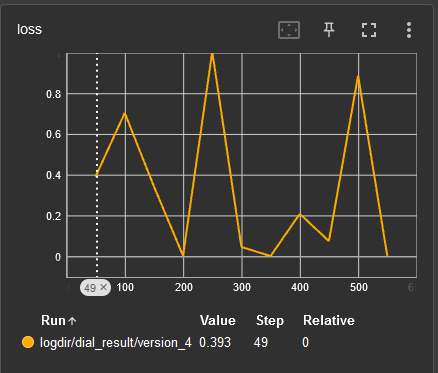

In [ ]:
torch.save(model.state_dict(), '../data/models/dial_emb64_model.pt')

## Эмбеддинги

In [ ]:
device  = torch.device("cuda")
model = model.to(device)

train_emb_df = get_train_dataset(processed_train, model, sorted(target_train.mon.sort_values().unique()), device)
val_emb_df = get_val_dataset(processed_test, model, sorted(target_test.mon.sort_values().unique()), device)
test_emb_df = get_test_dataset(processed_test, model, device)

In [ ]:
train_emb_df.to_csv('../data/train_dial_emb_v8.csv', index=False)
val_emb_df.to_csv('../data/val_dial_emb_v8.csv', index=False)
test_emb_df.to_csv('../data/test_dial_emb_v8.csv', index=False)